# Extract candidate features from an image

In [3]:
%matplotlib inline

import os
import sys
import glob

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import cv2
from skimage.measure import regionprops
import skimage
from skimage.segmentation import find_boundaries

#import seaborn as sns

In [4]:
from functools import partial

In [5]:
from numba import jit

## Change path as appropriate for where your target images are

In [6]:
pos_path = os.path.join('mouse_16.5_20x', 'distal_acinar_tubule')
neg_path = os.path.join('mouse_16.5_20x', 'distal_acinar_tubule_negative')

## Candidate feature functions

Currently all are color-based and return a scalar for the 2D array for each color (R, G,, B).

In [7]:
def mean_color(xs):
    """Return a vector of the mean value for each color."""
    return np.ma.mean(xs, axis=(0,1))

def std_color(xs):
    """Return a vector of the standard deviation for each color."""
    return np.ma.std(xs, ddof=1, axis=(0,1))

@jit
def moment_color(xs, d=2):
    """Returns the central moments of order d.
    
    May not be numerically stable since there is risk of catastrophic cancellation.
    """
    ans = np.zeros(3)
    for i in range(3):
        ys = np.ma.masked_array(xs[:,:,i])
        m = np.ma.sum((ys - np.ma.mean(ys))**d)
        ans[i] = m/ys.count()
    return ans

def pm_area_ratio(xs):

    """Return perimeter and area ratio for region inside contour."""
    
    xs_avg = (xs[:,:,0]+xs[:,:,1]+xs[:,:,2])/3
    len_h = []
    len_v = []
    for i in range (0,xs_avg.shape[0]-1):
        lengthi = sum(xs_avg[i+1,:]==-1) - sum(xs_avg[i,:]==-1)
        len_h.append(abs(lengthi))

    for j in range (0,xs_avg.shape[1]-1):
        lengthj = sum(xs_avg[:,j+1]==-1) - sum(xs_avg[:,j]==-1)
        len_v.append(abs(lengthj))

    perimeter = sum(len_h) + sum(len_v)
    area = np.sum(xs[:,:] != -1)
    ratio = perimeter/area
    return np.array(ratio)

def entropy(xs):
    """Return a vector of the entropy for each color."""
    
    ent = np.zeros(3)
    for i in range(3):
        hist = np.histogram(xs[:,:,i], bins=256, normed=True)[0]
        ent[i]=np.sum([p*np.log2(1.0/p) for p in hist if p>0])
    return ent

def major_axis_length(xs):
    props = regionprops(f_)[0]
    return props[major_axis_length]
def minor_axis_length(xs):
    props = regionprops(f_)[0]
    return props[minor_axis_length]
def orientation(xs):
    props = regionprops(f_)[0]
    return props[orientation]
def equivalent_diameter(xs):
    props = regionprops(f_)[0]
    return props[equivalent_diameter]
def perimeter(xs):
    props = regionprops(f_)[0]
    return props[perimeter]
def solidity(xs):
    props = regionprops(f_)[0]
    return props[solidity]

# Pleas add more features that you think might be useful
# Each function should return a list or vector, even if it returns a scalar

In [ ]:
"""This cell defines the function for calculating `Fourier shape descriptors`"""

def ComputeFSDFeatures(im_label, K=128, Fs=6, Delta=8, rprops=None):
    #The following two lines are written by me. The rest of this cell are directly copied.
    #Convert image to binary image because FSDs are related with "shape"
    im_label[im_label != -1] = 1
    
    """
    Calculates `Fourier shape descriptors` for each objects.

    Parameters
    ----------
    im_label : array_like
        A labeled mask image wherein intensity of a pixel is the ID of the
        object it belongs to. Non-zero values are considered to be foreground
        objects.
    K : int, optional
        Number of points for boundary resampling to calculate fourier
        descriptors. Default value = 128.
    Fs : int, optional
        Number of frequency bins for calculating FSDs. Default value = 6.
    Delta : int, optional
        Used to dilate nuclei and define cytoplasm region. Default value = 8.

    rprops : output of skimage.measure.regionprops, optional
        rprops = skimage.measure.regionprops( im_label ). If rprops is not
        passed then it will be computed inside which will increase the
        computation time.

    Returns
    -------
    fdata: Pandas data frame containing the FSD features for each
           object/label.

    References
    ----------
    .. [1] D. Zhang et al. "A comparative study on shape retrieval using
       Fourier descriptors with different shape signatures," In Proc.
       ICIMADE01, 2001.
    """
    # List of feature names
    feature_list = []
    for i in range(0, Fs):
        feature_list = np.append(feature_list, 'Shape.FSD' + str(i+1))

    # get Label size x
    sizex = im_label.shape[0]
    sizey = im_label.shape[1]

    # get the number of objects in Label
    if rprops is None:
        rprops = regionprops(im_label)

    # create pandas data frame containing the features for each object
    numFeatures = len(feature_list)
    numLabels = len(rprops)
    fdata = pd.DataFrame(np.zeros((numLabels, numFeatures)),
                         columns=feature_list)

    # fourier descriptors, spaced evenly over the interval 1:K/2
    Interval = np.round(
        np.power(
            2, np.linspace(0, np.log2(K)-1, Fs+1, endpoint=True)
        )
    ).astype(np.uint8)

    for i in range(numLabels):
        # get bounds of dilated nucleus
        min_row, max_row, min_col, max_col = \
            _GetBounds(rprops[i].bbox, Delta, sizex, sizey)
        # grab label mask
        lmask = (
            im_label[min_row:max_row, min_col:max_col] == rprops[i].label
        ).astype(np.bool)
        # find boundaries
        Bounds = np.argwhere(
            find_boundaries(lmask, mode="inner").astype(np.uint8) == 1
        )
        # check length of boundaries
        if len(Bounds) < 2:
            fdata.at[i, :] = 0
        else:
            # compute fourier descriptors
            fdata.at[i, :] = _FSDs(Bounds[:, 0], Bounds[:, 1], K, Interval)

    return fdata

def _InterpolateArcLength(X, Y, K):
    """
    Resamples boundary points [X, Y] at L total equal arc-length locations.

    Parameters
    ----------
    X : array_like
        x points of boundaries
    Y : array_like
        y points of boundaries
    K : int
        Number of points for boundary resampling to calculate fourier
        descriptors. Default value = 128.

    Returns
    -------
    iX : array_like
        L-length vector of horizontal interpolated coordinates with equal
        arc-length spacing.
    iY : array_like
        L-length vector of vertical interpolated coordinates with equal
        arc-length spacing.
    """

    # generate spaced points 0, 1/k, 1
    interval = np.linspace(0, 1, K+1)
    # get segment lengths
    slens = np.sqrt(np.diff(X)**2 + np.diff(Y)**2)
    # normalize to unit length
    slens = np.true_divide(slens, slens.sum())
    # calculate cumulative length along boundary
    cumulative = np.zeros(len(slens)+1)
    cumulative[1:] = np.cumsum(slens)
    # place points in 'Interval' along boundary
    locations = np.digitize(interval, cumulative)
    # clip to ends
    locations[locations > len(slens)] = len(slens)
    # linear interpolation
    Lie = (interval - cumulative[locations-1])/slens[locations-1]
    iX = X[locations-1] + (X[locations]-X[locations-1])*Lie
    iY = Y[locations-1] + (Y[locations]-Y[locations-1])*Lie

    return iX, iY


def _FSDs(X, Y, K, Intervals):
    """
    Calculated FSDs from boundary points X,Y. Boundaries are resampled to have
    K equally spaced points (arclength) around the shape. The curvature is
    calculated using the cumulative angular function, measuring the
    displacement of the tangent angle from the starting point of the boundary.
    The K-length fft of the cumulative angular function is calculated, and
    then the elements of 'F' are summed as the spectral energy over
    'Intervals'.

    Parameters
    ----------
    X : array_like
        x points of boundaries
    Y : array_like
        y points of boundaries
    K : int
        Number of points for boundary resampling to calculate fourier
        descriptors. Default value = 128.
    Intervals : array_like
        Intervals spaced evenly over 1:K/2.

    Returns
    -------
    F : array_like
        length(Intervals) vector containing spectral energy of
        cumulative angular function, summed over defined 'Intervals'.
    """

    # check input 'Intervals'
    if Intervals[0] != 1.:
        Intervals = np.hstack((1., Intervals))
    if Intervals[-1] != (K / 2):
        Intervals = np.hstack((Intervals, float(K)))
    # get length of intervals
    L = len(Intervals)
    # initialize F
    F = np.zeros((L-1, )).astype(float)
    # interpolate boundaries
    iX, iY = _InterpolateArcLength(X, Y, K)
    # check if iXY.iX is not empty
    if iX.size:
        # calculate curvature
        Curvature = np.arctan2(
            (iY[1:] - iY[:-1]),
            (iX[1:] - iX[:-1])
        )
        # make curvature cumulative
        Curvature = Curvature - Curvature[0]
        # calculate FFT
        fX = np.fft.fft(Curvature).T
        # spectral energy
        fX = fX * fX.conj()
        fX = fX / fX.sum()
        # calculate 'F' values
        for i in range(L-1):
            F[i] = np.round(
                fX[Intervals[i]-1:Intervals[i+1]].sum(), L
            ).real.astype(float)

    return F


def _GetBounds(bbox, delta, M, N):
    """
    Returns bounds of object in global label image.

    Parameters
    ----------
    bbox : tuple
        Bounding box (min_row, min_col, max_row, max_col).
    delta : int
        Used to dilate nuclei and define cytoplasm region.
        Default value = 8.
    M : int
        X size of label image.
    N : int
        Y size of label image.

    Returns
    -------
    min_row : int
        Minum row of the region bounds.
    max_row : int
        Maximum row of the region bounds.
    min_col : int
        Minum column of the region bounds.
    max_col : int
        Maximum column of the region bounds.
    """

    min_row, min_col, max_row, max_col = bbox

    min_row_out = max(0, (min_row - delta))
    max_row_out = min(M-1, (max_row + delta))
    min_col_out = max(0, (min_col - delta))
    max_col_out = min(N-1, (max_col + delta))

    return min_row_out, max_row_out, min_col_out, max_col_out

In [8]:
feature_map = dict(
    mean_color=mean_color, 
    std_color=std_color, 
    moment_color_2=moment_color,
    moment_color_3=partial(moment_color, d=3),
    pm_area_ratio=pm_area_ratio,
    entropy=entropy,
    major_axis_length=major_axis_length,
    minor_axis_length=minor_axis_length,
    orientation=orientation,
    equivalent_diameter=equivalent_diameter,
    perimeter=perimeter,
    solidity=solidity,
    ComputeFSDFeatures=ComputeFSDFeatures
    )

In [ ]:
feature_map[feature]

In [22]:
def build_features(xs, features):
    ans = []
    for feature in features:
        f = feature_map[feature]
        ans.append(f(xs))
    return np.concatenate(ans)

## Construct a vector of features for each image

In [8]:
features = ['mean_color', 'std_color', 'moment_color_2', 'moment_color_3', 'pm_area_ratio', 'entropy', 
            "major_axis_length", "minor_axis_length", "orientation","equivalent_diameter",
               "perimeter","solidity",'ComputeFSDFeatures']
image_features = {}
pos_files = glob.glob(os.path.join(pos_path, '*npy'))
for f in pos_files[:3]:
    path, filename = os.path.split(f)
    name, ext = os.path.splitext(filename)
    xs = np.load(f)
    ys = np.ma.masked_array(xs, mask=xs==-1)
    image_features[name] = build_features(ys, features)

In [9]:
image_features

{'2015-04-029_20X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_001__1002,2261_': masked_array(data = [  1.08400208e+02   1.92591476e+02   1.17720028e+02   3.29237381e+01
    5.28633678e+01   3.94607753e+01   1.08359694e+03   2.79356734e+03
    1.55661323e+03  -2.31908577e+04  -1.32818538e+05   6.62708433e+04],
              mask = False,
        fill_value = 1e+20),
 '2015-04-029_20X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_001__1013,863_': masked_array(data = [  1.03080769e+02   2.08451923e+02   1.48193910e+02   3.58055364e+01
    5.37714840e+01   6.13857755e+01   1.28162553e+03   2.89044577e+03
    3.76700567e+03  -6.11707902e+03  -2.24180854e+05   6.83214785e+04],
              mask = False,
        fill_value = 1e+20),
 '2015-04-029_20X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_001__1016,1004_': masked_array(data = [  1.27169851e+02   2.27410120e+02   1.32866596e+02   3.09789564e+01
    3.88830134e+01   6.50199444e+01   9.59356147e+02   1.51135374e+03
    4.22609721e+03  -3.

In [12]:
pos_path = "G:\\2016\\Summer\\LungMAP\\Advanced\\segmented\\proximal_acinar_tubule"
neg_path = "G:\\2016\\Summer\\LungMAP\\Advanced\\segmented\\distal_acinar_tubule_negative"

In [26]:
pos_files;

In [40]:
#Test for entropy
features = ['mean_color', 'std_color', 'moment_color_2', 'moment_color_3', 'pm_area_ratio', 'entropy']
features_sub = ['entropy']
image_features_pos = {}
image_features_neg = {}
pos_files = glob.glob(os.path.join(pos_path, '*tif'))
neg_files = glob.glob(os.path.join(neg_path, '*tif'))
for f in pos_files:
    path, filename = os.path.split(f)
    name, ext = os.path.splitext(filename)
    im = cv2.imread(f)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    xs = np.array(im)
    ys = np.ma.masked_array(xs, mask=xs==-1)
    image_features_pos[name] = build_features(ys, features_sub)
for f in neg_files:
    path, filename = os.path.split(f)
    name, ext = os.path.splitext(filename)
    im = cv2.imread(f)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    xs = np.array(im)
    ys = np.ma.masked_array(xs, mask=xs==-1)
    image_features_neg[name] = build_features(ys, features_sub)

In [70]:
# positive acinar tubules
a = image_features_pos
a_list = []
for key, value in a.items():
    temp = [key,value]
    a_list.append(temp)
    
a_r = []
for j in range(len(a_list)):
    a_r.append(a_list[j][1][0])
    
a_g = []
for j in range(len(a_list)):
    a_g.append(a_list[j][1][1])
    
a_b = []
for j in range(len(a_list)):
    a_b.append(a_list[j][1][2])

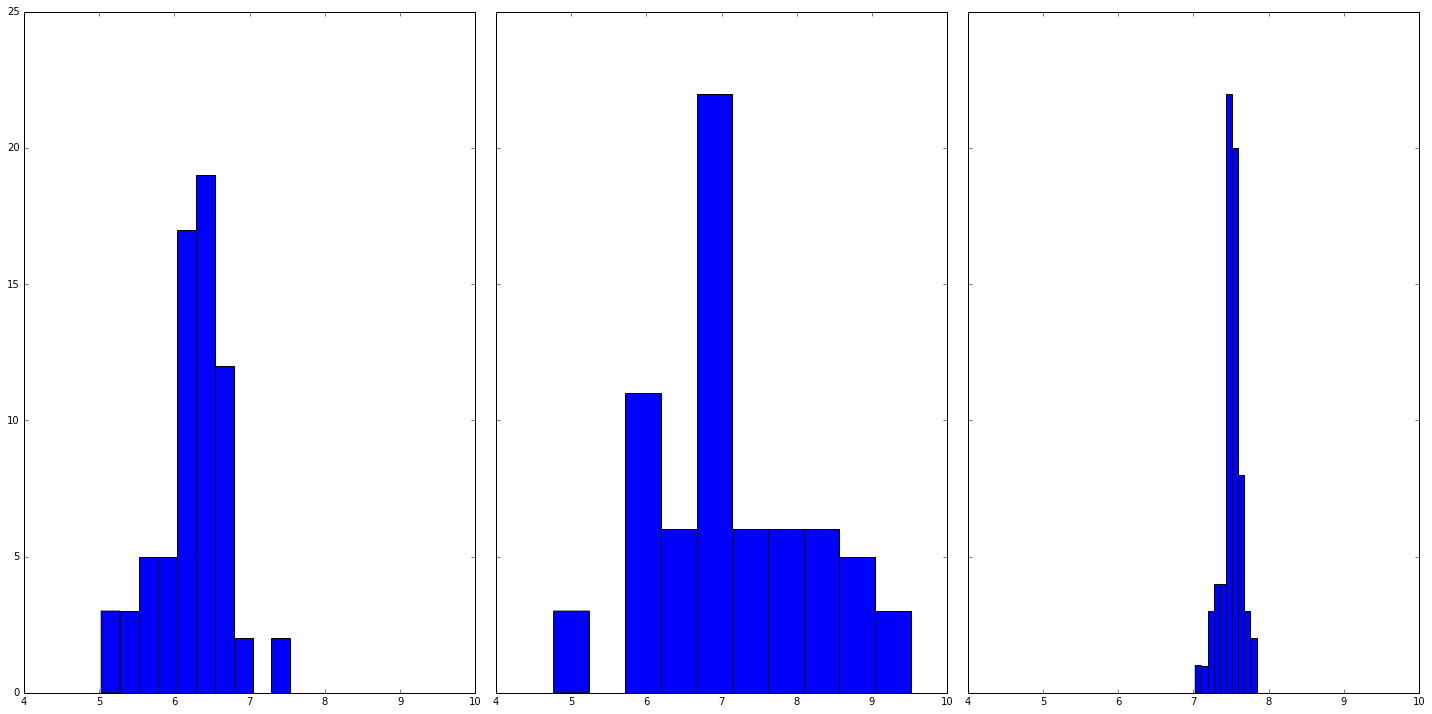

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
axes[0].hist(a_r)
axes[1].hist(a_g)
axes[2].hist(a_b)
plt.tight_layout()

In [78]:
# negative acinar tubules
b = image_features_neg
b_list = []
for key, value in b.items():
    temp = [key,value]
    b_list.append(temp)
    
b_r = []
for j in range(len(b_list)):
    b_r.append(b_list[j][1][0])
    
b_g = []
for j in range(len(b_list)):
    b_g.append(b_list[j][1][1])
    
b_b = []
for j in range(len(b_list)):
    b_b.append(b_list[j][1][2])

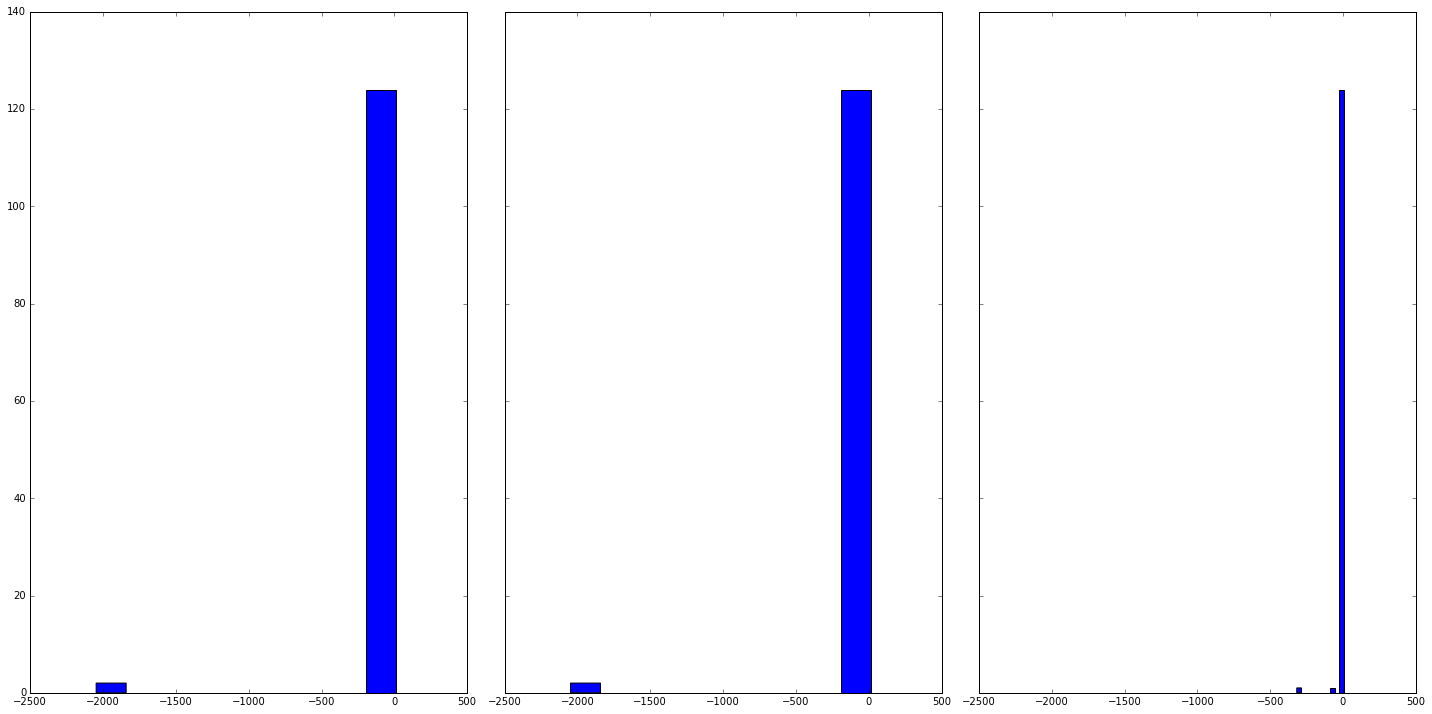

In [79]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
axes[0].hist(b_r)
axes[1].hist(b_g)
axes[2].hist(b_b)
plt.tight_layout()

In [80]:
# exclude almost totally black images (images with negative entropy)
# negative acinar tubules
b = image_features_neg
b_list = []
for key, value in b.items():
    temp = [key,value]
    b_list.append(temp)
    
b_r = []
for j in range(len(b_list)):
    if b_list[j][1][0]>0:
        b_r.append(b_list[j][1][0])
    
b_g = []
for j in range(len(b_list)):
    if b_list[j][1][1]>0:
        b_g.append(b_list[j][1][1])
    
b_b = []
for j in range(len(b_list)):
    if b_list[j][1][2]>0:
        b_b.append(b_list[j][1][2])

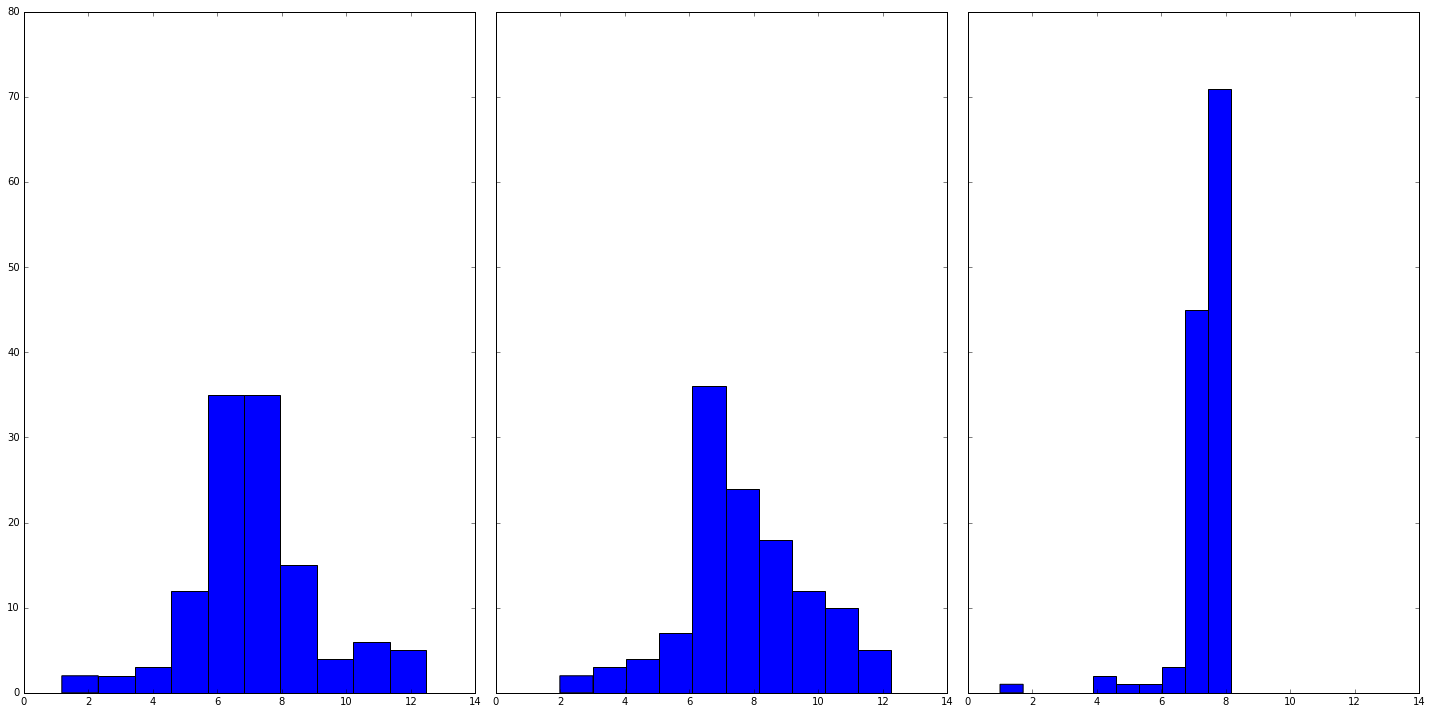

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
axes[0].hist(b_r)
axes[1].hist(b_g)
axes[2].hist(b_b)
plt.tight_layout()